In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import cv2
import math
from scipy.misc import imread
from scipy.misc import imresize

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)


## Load data

In [2]:
##loading data
csv_path='/Users/simin/Desktop/data/driving_log.csv'
data_files_s=pd.read_csv(csv_path,header=None,names=['center','left','right','steer','throttle','break'], index_col=False)
data_files_s['direction']=pd.Series('s',index=data_files_s.index)


In [3]:
data_files_s.head()

,center,left,right,steer,throttle,break,direction
0,/Users/simin/Desktop/data/IMG/center_2017_03_2...,/Users/simin/Desktop/data/IMG/left_2017_03_20_...,/Users/simin/Desktop/data/IMG/right_2017_03_20...,0.0,0.0,0.0,s
1,/Users/simin/Desktop/data/IMG/center_2017_03_2...,/Users/simin/Desktop/data/IMG/left_2017_03_20_...,/Users/simin/Desktop/data/IMG/right_2017_03_20...,0.0,0.0,0.0,s
2,/Users/simin/Desktop/data/IMG/center_2017_03_2...,/Users/simin/Desktop/data/IMG/left_2017_03_20_...,/Users/simin/Desktop/data/IMG/right_2017_03_20...,0.0,0.0,0.0,s
3,/Users/simin/Desktop/data/IMG/center_2017_03_2...,/Users/simin/Desktop/data/IMG/left_2017_03_20_...,/Users/simin/Desktop/data/IMG/right_2017_03_20...,0.0,0.0,0.0,s
4,/Users/simin/Desktop/data/IMG/center_2017_03_2...,/Users/simin/Desktop/data/IMG/left_2017_03_20_...,/Users/simin/Desktop/data/IMG/right_2017_03_20...,0.0,0.0,0.0,s


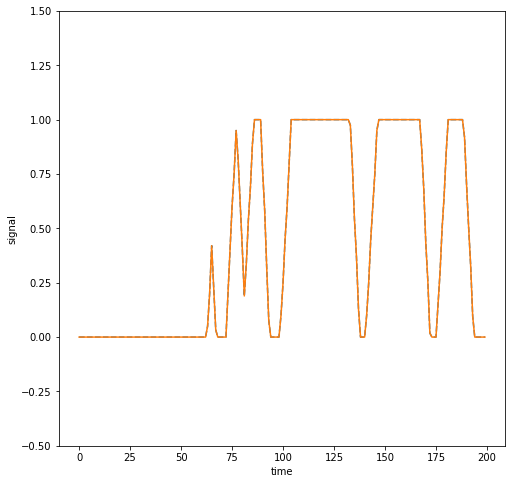

In [4]:
len_plt=200
rev_steer_s=np.array(data_files_s.steer,dtype=np.float32)

t_s=np.arange(len(rev_steer_s))
x_s=np.array(data_files_s.steer)
y_s=rev_steer_s

plt.plot(t_s[0:len_plt],x_s[0:len_plt], '--',t_s[0:len_plt], y_s[0:len_plt]);
plt.xlabel('time')
plt.ylabel('signal')
plt.ylim(-0.5,1.5);

data_files_s['steer_sm']=pd.Series(rev_steer_s, index=data_files_s.index)

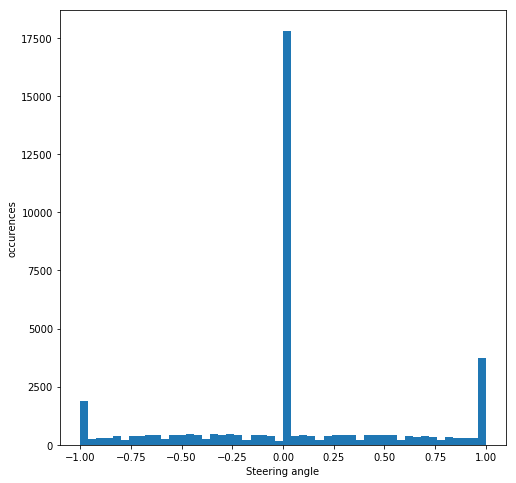

In [5]:
fig,ax=plt.subplots()
ax.set_xlabel('Steering angle')
ax.set_ylabel('occurences')

# ax.set_title("hst")
angles=data_files_s['steer_sm']
plt.hist(angles,bins=50)
plt.show()

In [6]:
data_files_s[20:25]
len(data_files_s)


40135

In [7]:
ind=data_files_s['throttle']>0.25
data_files_s=data_files_s[ind].reset_index() ##only reorganize the index which the throttle
##value >0.25, for others are romved from the data frame
len(data_files_s)

10196

In [65]:
def process_image_file(name):
    image=cv2.imread(name)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image=image/255.-.5
    return image

### augmentation
* adjusting left and right angles with corresponding left/right images

In [66]:
ind_num=np.random.randint(10195)
image_c=process_image_file(data_files_s['center'][ind_num].strip())
image_c=image_c[50:image_c.shape[0]-25,0:image_c.shape[1],:]

image_l=process_image_file(data_files_s['left'][ind_num].strip())
image_l=image_l[50:image_l.shape[0]-25,0:image_l.shape[1],:]
image_r=process_image_file(data_files_s['right'][ind_num].strip())


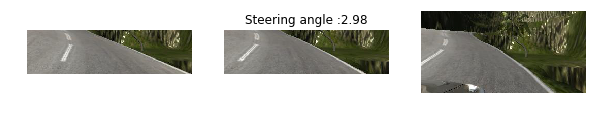

In [67]:
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(image_l+.5);
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(image_c+.5);
plt.axis('off')
plt.title('Steering angle :'+str(np.round(y_s[ind_num]*25,2)));
plt.subplot(1,3,3)
plt.imshow(image_r+.5)
plt.axis('off');


In [68]:
def plot_camera_images(data,steer_sm,ind_num, deg=0):
    image_c=process_image_file(data['center'][ind_num].strip())
    image_l=process_image_file(data['left'][ind_num].strip())
    image_r=process_image_file(data['right'][ind_num].strip())
    plt.subplot(1,3,1)
    plt.imshow(image_l+.5);
    plt.axis('off')
    if deg==0:
        plt.title('steer'+str(np.round(steer_sm[ind_num]+.25,2)));
    else:
        plt.title('steer'+str(np.round((steer_sm[ind_num]+.1)*180/np.pi,2)))
        
    plt.subplot(1,3,2)
    plt.imshow(image_c+.5)
    plt.axis('off')
    if deg==0:
        plt.title('steer'+ str(np.round(steer_sm[ind_num],2)));
    else:
        plt.title('steer'+str(np.round(steer_sm[ind_num]*180/np.pi,2)));
        
    plt.subplot(1,3,3)
    plt.imshow(image_r+.5);
    plt.axis('off')
    if deg==0:
        plt.title('steer'+str(np.round(steer_sm[ind_num]-.25,2)));
    else:
        plt.title('steer'+str(np.round((steer_sm[ind_num]-.1)*180/np.pi,2)));
        

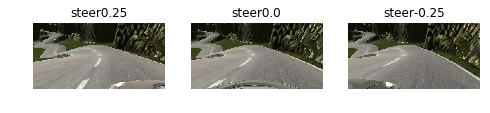

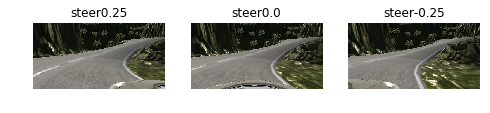

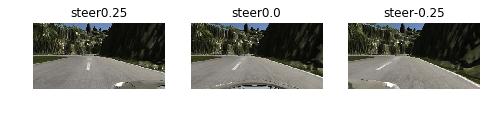

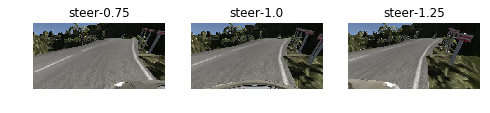

In [69]:
for i in range(4):
    i_random=np.random.randint(len(data_files_s)-1)
    plt.figure(figsize=(8,16))
    plot_camera_images(data_files_s,rev_steer_s,i_random,0)
    plt.show()

**brightness augmentation**

In [24]:
def augment_brightness_camera_images(image):
    image1=cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_bright=.25+np.random.uniform() ##scale the value (0.25,1.25)
    image1[:,:,2]=image1[:,:,2]*random_bright
    image1=cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1


In [25]:
image2=cv2.imread(data_files_s['center'][0].strip())
image2=cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)


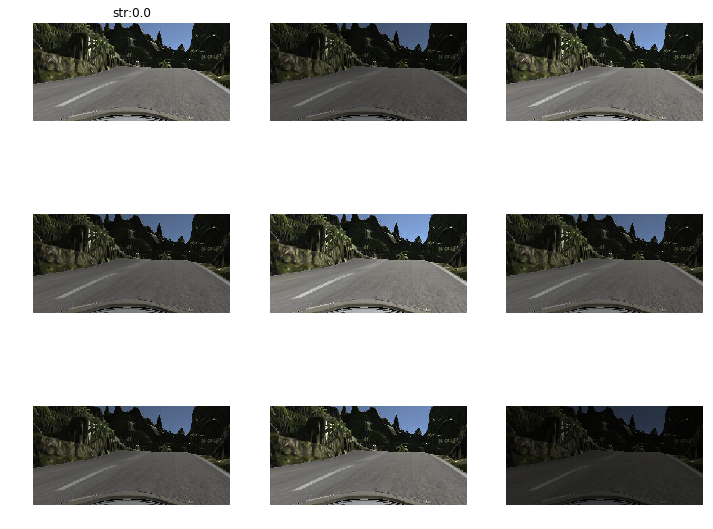

In [42]:

plt.figure(figsize=(12,10))
plt.subplot(3,3,1)
plt.imshow(image2)
plt.title('str:'+str(np.round(steer,2)))
plt.axis('off')

for i in range(8):
    image1=augment_brightness_camera_images(image2)
#     print(image1.shape)
    plt.subplot(3,3,i+2)
    plt.imshow(image1)
    plt.axis('off')
plt.show()

**left/right and up/down translation**

In [35]:
image=cv2.imread(data_files_s['center'][80].strip())
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
steer=data_files_s['steer_sm'][1]
image_l=cv2.imread(data_files_s['left'][80].strip())
image_l=cv2.cvtColor(image_l,cv2.COLOR_BGR2RGB)

In [36]:
def trans_image(image, steer, trans_range):
    ##translation
    rows,cols,ch=image.shape
    tr_x=trans_range*np.random.uniform()-trans_range/2
    steer_ang=steer+tr_x/trans_range*2*.2
    tr_y=10*np.random.uniform()-10/2
    Trans_m=np.float32([[1,0,tr_x],[0,1,tr_y]]) ##transform matrix
    image_tr=cv2.warpAffine(image,Trans_m,(cols,rows))
    
    return image_tr,steer_ang,tr_x

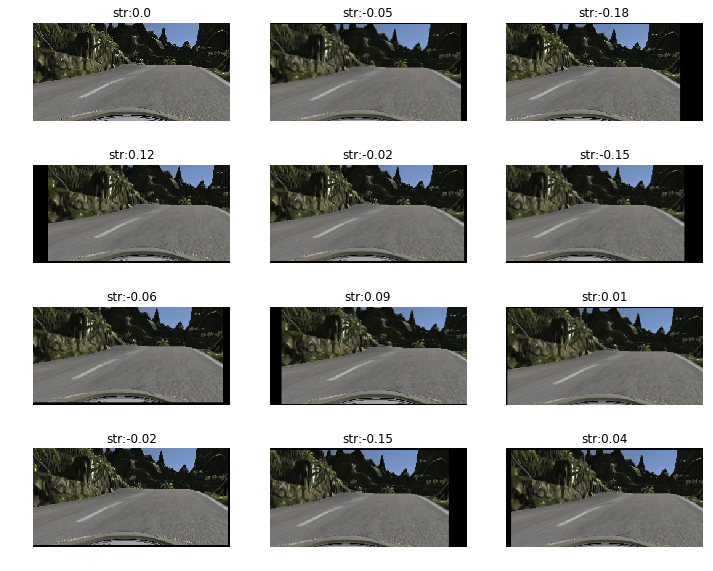

In [37]:
plt.figure(figsize=(12,10))
plt.subplot(4,3,1)
plt.imshow(image)
plt.title('str:'+str(np.round(steer,2)))
plt.axis('off')

for i in range(11):
    plt.subplot(4,3,i+2)
    image_tr,steer_ang,tr_x=trans_image(image,steer,80)
    plt.title('str:'+str(np.round(steer_ang,2)))
    plt.imshow(image_tr)
    plt.axis('off')

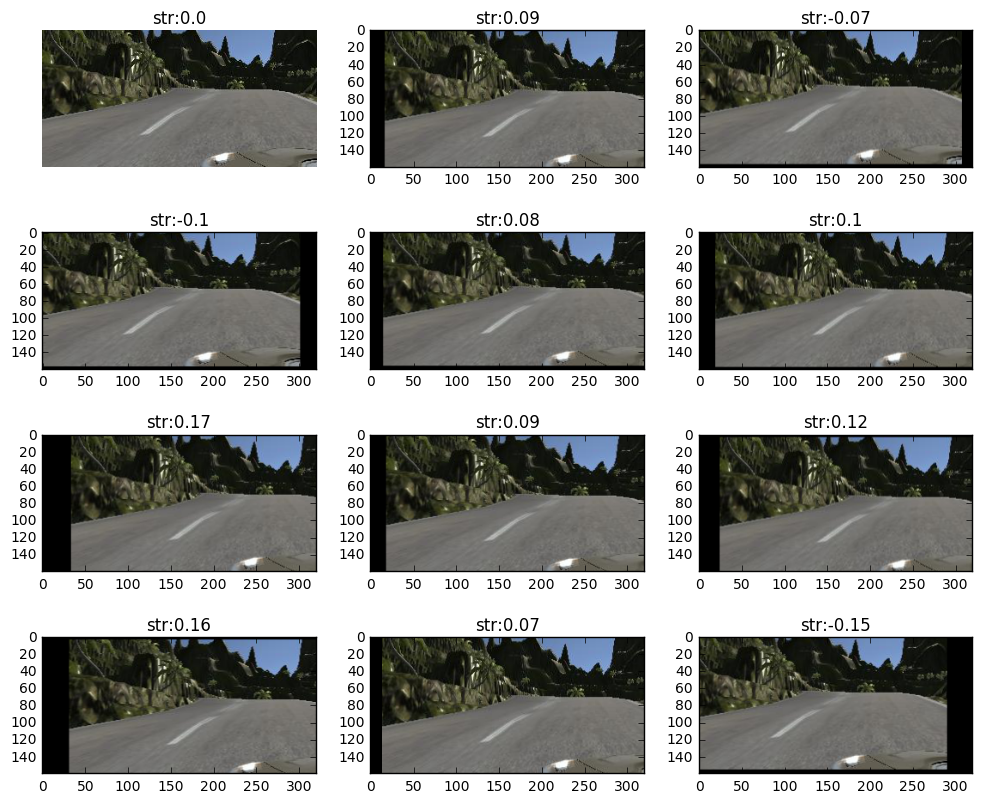

In [18]:
plt.figure(figsize=(12,10))
plt.subplot(4,3,1)
plt.imshow(image_l)
plt.title('str:'+str(np.round(steer,2)))
plt.axis('off')

for i in range(11):
    plt.subplot(4,3,i+2)
    image_tr,steer_ang,tr_x=trans_image(image_l,steer,80)
    plt.title('str:'+str(np.round(steer_ang,2)))
    plt.imshow(image_tr)
#     plt.axis('off')

**shadow generation**

In [48]:
def generateShadow(image):
    h,w,ch=image.shape
    rand=np.random.randint(2)
    
    if(rand==0):
        x=np.random.uniform(50,150)
        fit=np.polyfit((0,x),(160,80),1)
        
    else:
        x=np.random.uniform(200,250)
        fit=np.polyfit((x,w),(80,h),1)
        
    for i in range(h):
              
        c=int((i-fit[1])/fit[0])

        image[i,:c,:]=(image[i,:c,:]*0.5).astype(np.int32)       
                       
    return image 


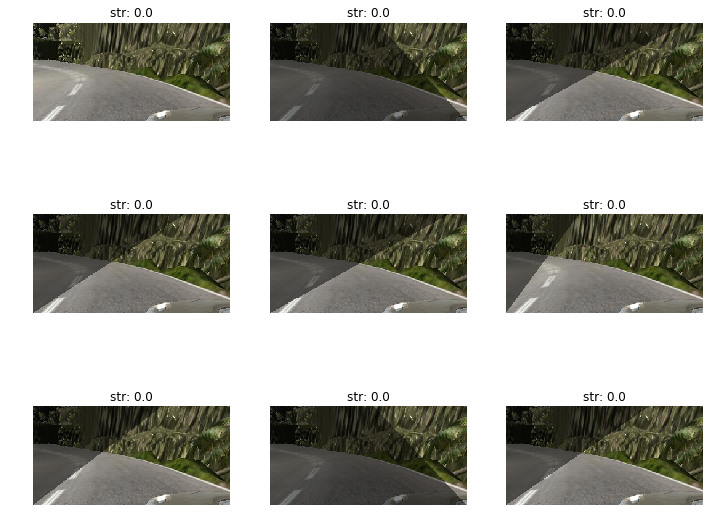

In [54]:
from copy import deepcopy

indd=np.random.randint(5000)
im = cv2.imread(data_files_s['left'][indd].strip())
steer = data_files_s['steer_sm'][indd]
im=cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,10))
plt.subplot(3,3,1)
plt.imshow(im)
plt.title('str: ' + str(np.round(steer,2)))
plt.axis('off')

for i in range(8):
    plt.subplot(3,3,i+2)
    imm=deepcopy(im)
    image_=generateShadow(imm)
    plt.title('str: ' + str(np.round(steer,2)) )
    plt.imshow(image_)
    plt.axis('off');

***Preprocessing***

In [19]:
##crop the top 1/4 of the image bottom 25 pixels, 
##rescale the image to 64x64
new_size_col=64
new_size_row=64

def preprocessImage(image):
    shape=image.shape
    ##numpy arrays are (row,col)
    image=image[50:shape[0]-25,0:shape[1]]
    image=cv2.resize(image, (new_size_col,new_size_row),interpolation=cv2.INTER_AREA)
    return image

def preprocess_image_file_train(line_data):
    i_lrc=np.random.randint(3)
    if(i_lrc==0):
        path_file=line_data['left'][0].strip()
        shift_ang=.25
    if(i_lrc==1):
        path_file=line_data['center'][0].strip()
        shift_ang=0.
    if(i_lrc==2):
        path_file=line_data['right'][0].strip()
        shift_ang=-.25
        
    y_steer=line_data['steer_sm'][0]+shift_ang
    image=cv2.imread(path_file)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image=preprocessImage(image)
    image,y_steer,tr_x=trans_image(image, y_steer,100)
    image=augment_brightness_camera_images(image)
    image=generateShadow(image)
    image=preprocessImage(image)
    image=np.array(image)
    
    ##randomly flip input image
    ind_flip=np.random.randint(2)
    if ind_flip==0:
        image=cv2.flip(image,1)
        y_steer=-y_steer
    return image, y_steer

In [20]:
data_files_s[0:10]

,index,center,left,right,steer,throttle,break,direction,steer_sm
0,23,/Users/simin/Desktop/data/IMG/center_2017_03_2...,/Users/simin/Desktop/data/IMG/left_2017_03_20_...,/Users/simin/Desktop/data/IMG/right_2017_03_20...,0.0,0.408081,0.0,s,0.0
1,24,/Users/simin/Desktop/data/IMG/center_2017_03_2...,/Users/simin/Desktop/data/IMG/left_2017_03_20_...,/Users/simin/Desktop/data/IMG/right_2017_03_20...,0.0,0.663399,0.0,s,0.0
2,25,/Users/simin/Desktop/data/IMG/center_2017_03_2...,/Users/simin/Desktop/data/IMG/left_2017_03_20_...,/Users/simin/Desktop/data/IMG/right_2017_03_20...,0.0,0.831180,0.0,s,0.0
3,26,/Users/simin/Desktop/data/IMG/center_2017_03_2...,/Users/simin/Desktop/data/IMG/left_2017_03_20_...,/Users/simin/Desktop/data/IMG/right_2017_03_20...,0.0,1.000000,0.0,s,0.0
4,27,/Users/simin/Desktop/data/IMG/center_2017_03_2...,/Users/simin/Desktop/data/IMG/left_2017_03_20_...,/Users/simin/Desktop/data/IMG/right_2017_03_20...,0.0,1.000000,0.0,s,0.0
5,28,/Users/simin/Desktop/data/IMG/center_2017_03_2...,/Users/simin/Desktop/data/IMG/left_2017_03_20_...,/Users/simin/Desktop/data/IMG/right_2017_03_20...,0.0,0.818857,0.0,s,0.0
6,29,/Users/simin/Desktop/data/IMG/center_2017_03_2...,/Users/simin/Desktop/data/IMG/left_2017_03_20_...,/Users/simin/Desktop/data/IMG/right_2017_03_20...,0.0,0.643444,0.0,s,0.0
7,30,/Users/simin/Desktop/data/IMG/center_2017_03_2...,/Users/simin/Desktop/data/IMG/left_2017_03_20_...,/Users/simin/Desktop/data/IMG/right_2017_03_20...,0.0,0.399937,0.0,s,0.0
8,58,/Users/simin/Desktop/data/IMG/center_2017_03_2...,/Users/simin/Desktop/data/IMG/left_2017_03_20_...,/Users/simin/Desktop/data/IMG/right_2017_03_20...,0.0,0.279108,0.0,s,0.0
9,59,/Users/simin/Desktop/data/IMG/center_2017_03_2...,/Users/simin/Desktop/data/IMG/left_2017_03_20_...,/Users/simin/Desktop/data/IMG/right_2017_03_20...,0.0,0.477570,0.0,s,0.0


In [21]:
# line_data=data_files_s.iloc[[2]].reset_index()##reset the only row corresponds
# ##to only the selected index(.loc[[2]], and all others are removed off)
# line_data['left'][0]

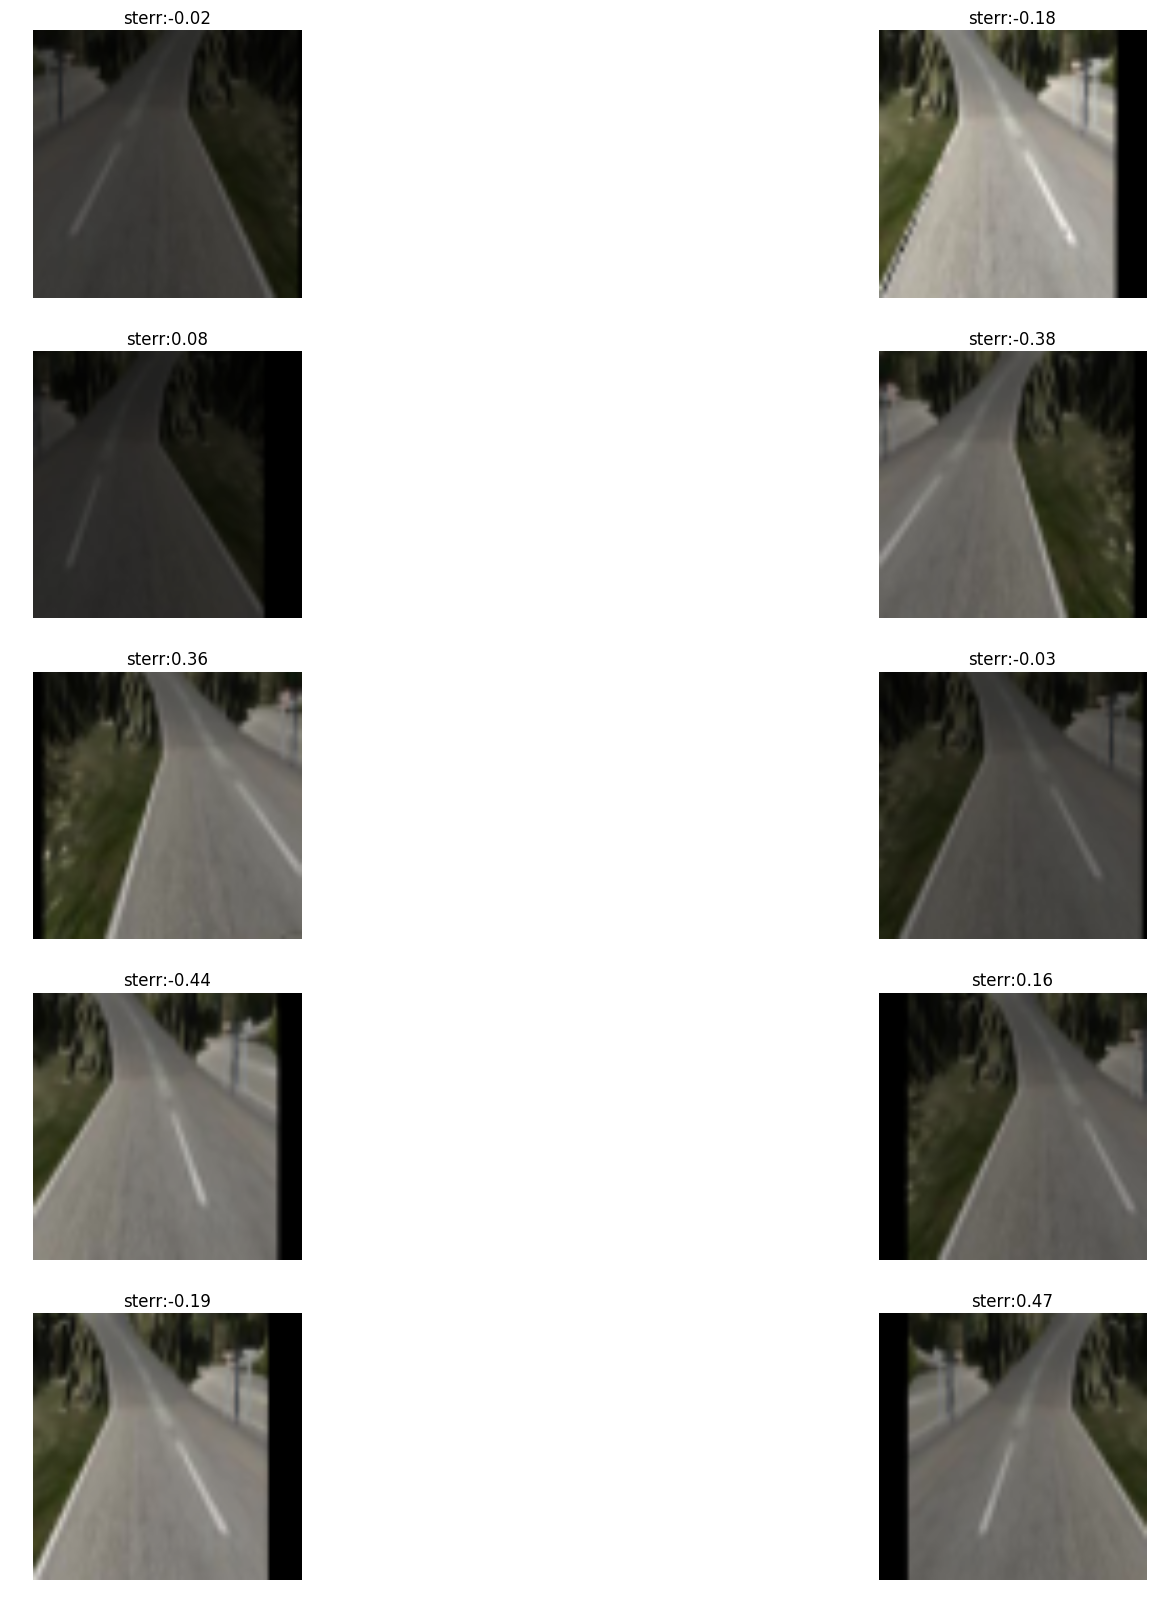

In [22]:
line_data=data_files_s.iloc[[2]].reset_index()
plt.figure(figsize=(20,20))
for i in range(10):
    image,steer=preprocess_image_file_train(line_data)
    plt.subplot(5,2,i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("sterr:"+str(np.round(steer,2)))

**Keras generator and subsampling**

In [58]:
# pr_threshold=0.5

def generate_train_from_batch(data,batch_size=32):
    batch_images=np.zeros((batch_size, new_size_row,new_size_col,3))
    batch_steering=np.zeros(batch_size)
    while 1:
        for i_batch in range(batch_size):
            i_line=np.random.randint(len(data))
            line_data=data.iloc[[i_line]].reset_index()
            
            keep_pr=0
            while keep_pr==0:
                x,y=preprocess_image_file_train(line_data)
    
#                 pr_unif=np.random
                if abs(y)<.15:
                    
                    pr_val=np.random.uniform()
                    if pr_val>pr_threshold:
                        keep_pr=1
                else:
                    keep_pr=1 ##end of loop
                    
            batch_images[i_batch]=x
            batch_steering[i_batch]=y
        yield batch_images, batch_steering

In [59]:
def preprocess_image_file_predict(line_data):
    path_line=line_data['center'][0].strip()
    image=cv2.imread(path_line)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image=preprocessImage(image)
    image=np.array(image)
    return image

# def generate_train(data):
#     while 1:
#         i_line=np.random.randint(len(data))
#         line_data=data.iloc[[i_line]].reset_index()
#         x,y=preprocess_image_file_train(line_data)
#         x=x.reshape(1,x.shape[0],x.shape[1],x.shape[2])
#         y=np.array([[y]])
#         yield x,y
        
def generate_valid(data):
    while 1:
        for i in range(len(data)):
            
            line_data=data.iloc[[i]].reset_index()
#             print(line_data)
            x=preprocess_image_file_predict(line_data)
            x=x.reshape(1,x.shape[0],x.shape[1],x.shape[2])
            y=line_data['steer_sm'][0]
            y=np.array([[y]]) ##set as column
            yield x,y  ##generate just one image
                 

###  generating image

In [61]:
# valid_s_generator=generate_valid(data_files_s)     
# for i in range(100):
#     next(valid_s_generator)
# img,steer=next(valid_s_generator)
# plt.imshow(img[0])
# plt.title('steer:'+str(np.round(steer,4)));

****Model architecture****

In [27]:
from keras.models import Sequential
from keras.layers.core import Dense,Dropout,Activation,Lambda
from keras.layers import Input,ELU
from keras.optimizers import SGD,Adam,RMSprop
from keras.utils import np_utils
from keras.layers import Convolution2D,MaxPooling2D,Flatten
from keras import initializations

Using TensorFlow backend.


In [28]:

new_size_row = 64
new_size_col = 64

model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.0,input_shape=(new_size_row,new_size_col,3)))
model.add(Convolution2D(3,1,1,border_mode='valid', init='he_normal'))
model.add(Convolution2D(32, 8,8 ,border_mode='same', subsample=(4,4)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 8,8 ,border_mode='same',subsample=(4,4)))
model.add(Activation('relu',name='relu2'))
model.add(Convolution2D(128, 4,4,border_mode='same',subsample=(2,2)))
model.add(Activation('relu'))
model.add(Convolution2D(128, 2,2,border_mode='same',subsample=(1,1)))
model.add(Activation('relu'))
model.add(Flatten())
# model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))




In [29]:
adam=Adam(lr=1e-4,beta_1=0.9, beta_2=0.999, epsilon=1e-08,
         decay=0.0)
model.compile(optimizer=adam,loss='mse')


**Training**

In [30]:
from pathlib import Path
import json

def save_model(fileModelJSON, fileWeights):
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string=model.to_json()
    with open(fileModelJSON, 'w')as f:
        json.dump(json_string,f)
        
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    model.save_weights(fileWeights)  

In [31]:
val_size=len(data_files_s)
pr_threshold=1

batch_size=256
i_best=0
val_best=1000

for i_pr in range(10):
    train_r_generator=generate_train_from_batch(data_files_s,batch_size)
    
    nb_vals=np.round(len(data_files_s)/val_size)-1
    print(nb_vals)
    
    history=model.fit_generator(train_r_generator, samples_per_epoch=20000,
                               nb_epoch=1, validation_data=valid_s_generator,
                               nb_val_samples=val_size)
    
    fileModelJSON='model_'+str(i_pr)+'.json'
    fileWeights='model_'+str(i_pr)+'.h5'
    
    save_model(fileModelJSON, fileWeights)
    
    val_loss=history.history['val_loss'][0]
    
    
    
    if val_loss<val_best:
        i_best=i_pr
        val_best=val_loss
        fileModelJSON='model_best.json'
        fileWeights='model_best.h5'
        save_model(fileModelJSON, fileWeights)
        
    pr_threshold=1/(i_pr+1)
    
    
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('model mean square erro loss')
#     plt.ylabel('mean square error loss')
#     plt.xlabel('epoch')
#     plt.legend(['training set', 'validation set'],
#               loc='upper right')
#     plt.show()
    
print('best model found at iteration #:'+str(i_best))
print('best validation score: '+str(np.round(val_best,4)))


0.0
Epoch 1/1
19968/20000 [============================>.] - ETA: 0s - loss: 0.2640

/Users/simin/anaconda/envs/IntroToTensorFlow/lib/python3.5/site-packages/keras/engine/training.py:1480: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


20224/20000 [==============================] - 369s - loss: 0.2635 - val_loss: 0.1306
0.0
Epoch 1/1
20224/20000 [==============================] - 382s - loss: 0.2446 - val_loss: 0.1285
0.0
Epoch 1/1
20224/20000 [==============================] - 442s - loss: 0.2175 - val_loss: 0.1072
0.0
Epoch 1/1
20224/20000 [==============================] - 437s - loss: 0.2045 - val_loss: 0.0954
0.0
Epoch 1/1
20224/20000 [==============================] - 385s - loss: 0.1811 - val_loss: 0.0874
0.0
Epoch 1/1
20224/20000 [==============================] - 385s - loss: 0.1774 - val_loss: 0.0793
0.0
Epoch 1/1
20224/20000 [==============================] - 396s - loss: 0.1746 - val_loss: 0.0788
0.0
Epoch 1/1
20224/20000 [==============================] - 384s - loss: 0.1664 - val_loss: 0.0783
0.0
Epoch 1/1
20224/20000 [==============================] - 389s - loss: 0.1661 - val_loss: 0.0773
0.0
Epoch 1/1
20224/20000 [==============================] - 383s - loss: 0.1631 - val_loss: 0.0777
best model fou